In [1]:
import numpy as np
from typing import Sequence, Tuple, Literal
import matplotlib.pyplot as plt
from radicalpy.shared import constants as C
import radicalpy as rp

In [2]:
fmn_neutral_hfcs = np.array([0.390, -0.769, -0.158, 0.2675, 0.393, 0.212])
fmn_neutral_atoms = ['H1', 'H5', 'H6', '8-CH3', 'N5', 'N10']
fmn_neutral_g = 2.0036

fmn_anion_hfcs = np.array([-0.35, 0.40, 0.73, 0.31])
fmn_anion_atoms = ['H6', '8-CH3', 'N5', 'N10']
fmn_anion_g = 2.0034

tyr_neutral_hfcs = np.array([0.15, -0.65, -0.65, 0.15, 0.77])
tyr_neutral_atoms = ['H2', 'H3', 'H5', 'H6', 'Hbeta']
tyr_neutral_g = 2.0041

trp_neutral_hfcs = np.array([-0.05, -0.40, 0.03, -0.32, -0.08, 0.29, 1.08, 0.25])
trp_neutral_atoms = ['H2', 'H4', 'H5', 'H6', 'H7', 'hbeta1', 'Hbeta2', 'N1']
trp_neutral_g = 2.0028

trp_cation_hfcs = np.array([-0.34, -0.47, -0.51, 0.06, -0.35, -0.21, 0.33, 0.84, 0.25])
trp_cation_atoms = ['NH(H1)', 'H2', 'H4', 'H5', 'H6', 'H7', 'hbeta1', 'Hbeta2', 'N1']
trp_cation_g = 2.0028

In [3]:
def enumerate_spin_states_from_base(base: int) -> np.ndarray:
    """
    Return all spin-state patterns for a mixed-radix 'base' (e.g. [2,2,3,...]).
    Each row corresponds to one configuration. For base[i]=b, the digit d in [0..b-1]
    maps to spin projection m = (b-1)/2 - d.
    """
    base = np.asarray(base, dtype=int)
    size = len(base)
    total = int(np.prod(base))

    # Build digits for all states at once via mixed-radix division
    # states: 0..total-1
    n = np.arange(total, dtype=np.int64)[:, None]  # (total, 1)
    digits = np.empty((total, size), dtype=np.int64)

    # Least-significant position first
    for i in range(size):
        b = base[i]
        digits[:, i] = n[:, 0] % b
        n //= b

    # Map digits -> spin projections m_i = (b-1)/2 - digit
    m = (base.astype(np.float64) - 1.0) / 2.0
    patterns = m[None, :] - digits.astype(np.float64)
    return patterns  # shape: (total, size)

In [4]:
enumerate_spin_states_from_base([2,2,2]).shape[0]

8

In [5]:
def s_t0_omega(deltag: float, B0: float, hfc_star: float, onuc_all: np.ndarray) -> Tuple[float, float]:
    """
    Compute the two radical pair frequencies ω+ and ω- (in rad/s) for S-T0 mixing.

    Parameters
    ----------
    deltag : float
        Difference in g-factors of the two radicals.
    b0 : float
        External magnetic field strength (Tesla).
    hfc_star : float
        Hyperfine coupling constant (rad/s) of the nucleus of interest.
    onuc_all : np.ndarray
        Array of total hyperfine contributions from all other nuclei (rad/s).

    Returns
    -------
    omega_plus : float
        The ω+ frequency (rad/s).
    omega_minus : float
        The ω- frequency (rad/s).
    """
    base_omega = (deltag * C.mu_B * B0) / C.hbar   # Δg μB B0 / ħ
    omega_plus  = base_omega + 0.5 * hfc_star + onuc_all
    omega_minus = base_omega - 0.5 * hfc_star + onuc_all
    return omega_plus, omega_minus

In [6]:
def cidnp_polarisation_exponential_model(ks: float, omega_plus: np.ndarray, omega_minus: np.ndarray) -> float:
    """
    Compute the CIDNP polarisation using the exponential model.

    Parameters
    ----------
    ks : float
        Singlet recombination rate (s^-1).
    omega_plus : np.ndarray
        Array of ω+ frequencies (rad/s).
    omega_minus : np.ndarray
        Array of ω- frequencies (rad/s).

    Returns
    -------
    p : float
        CIDNP polarisation.
    """
    ks2 = float(ks)**2
    term = (omega_plus**2) / (ks2 + 4.0 * omega_plus**2) \
            - (omega_minus**2) / (ks2 + 4.0 * omega_minus**2)
    return np.sum(term, dtype=np.float64)

In [7]:
def cidnp_polarisation_truncated_diffusion_model(omega_plus: np.ndarray, omega_minus: np.ndarray) -> float:
    """
    Compute the CIDNP polarisation using the truncated t^{-3/2} diffusion model.

    Parameters
    ----------
    omega_plus : np.ndarray
        Array of ω+ frequencies (rad/s).
    omega_minus : np.ndarray
        Array of ω- frequencies (rad/s).

    Returns
    -------
    p : float
        CIDNP polarisation.
    """
    return np.sum(np.sqrt(np.abs(omega_plus)) - np.sqrt(np.abs(omega_minus)), dtype=np.float64)

In [8]:
def cidnp_polarisation_diffusion_model(omega_plus: np.ndarray, omega_minus: np.ndarray, alpha: float = 1.5) -> float:
    """
    Compute the CIDNP polarisation using the full diffusion model.

    Parameters
    ----------
    omega_plus : np.ndarray
        Array of ω+ frequencies (rad/s).
    omega_minus : np.ndarray
        Array of ω- frequencies (rad/s).
    alpha : float
        Dimensionless parameter for the Adrian diffusion model 2p/m.

    Returns
    -------
    p : float
        CIDNP polarisation.
    """
    T_to_angular_frequency = 2.8e10 * 2.0 * np.pi
    op_T = omega_plus  / T_to_angular_frequency
    om_T = omega_minus / T_to_angular_frequency
    r_op = np.sqrt(np.abs(op_T))
    r_om = np.sqrt(np.abs(om_T))
    a = float(alpha)
    f = lambda r: 1.0 - np.exp(-a * r) * np.cos(a * r)
    return np.sum(f(r_op) - f(r_om), dtype=np.float64)

In [9]:
def cidnp(
    B0: np.ndarray,
    deltag: float,
    cidnp_model: str,
    nucleus_of_interest: int,
    donor_hfc_spinhalf: float,
    acceptor_hfc_spinhalf: float,
    donor_hfc_spin1: float,
    acceptor_hfc_spin1: float,
    ks: float | None = None,
    alpha: float | None = None,
) -> (np.ndarray, np.ndarray):
    """
    CIDNP polarisation vs field for a radical pair with S-T0 mixing only.
    Args:

        B0 (np.ndarray): External magnetic field (T).

        deltag (float): Difference in g-value between the acceptor
            and donor.

        cidnp_model: Choose between CIDNP kinetic models. a) Exponential
            model. b) Truncated diffusion model. c) Full diffusion model.

        ks (float): Decay rate constant for the Exponential model (1/s).

        alpha (float): Parameter for the full diffusion model.

        nucleus_of_interest (int): The nucleus chosen for the simulation.

        donor_hfc_spinhalf (float): spin 1/2 HFCs (1H) for the donor (mT).

        acceptor_hfc_spinhalf (float): spin 1/2 HFCs (1H) for the acceptor (mT).

        donor_hfc_spin1 (float): spin 1 HFCs (14N) for the donor (mT).

        acceptor_hfc_spin1 (float): spin 1 HFCs (14N) for the acceptor (mT).

    Returns:
        B0 (T)
        cidnp (polarisation at each field point)
    """

    # Constants
    T_to_angular_frequency = (
        2.8e10 * 2.0 * np.pi
    )  # (T -> rad/s) for hyperfine conversion

    dnuc, anuc, dnuc1, anuc1 = (
        len(donor_hfc_spinhalf),
        len(acceptor_hfc_spinhalf),
        len(donor_hfc_spin1),
        len(acceptor_hfc_spin1),
    )
    nnuc = dnuc + anuc  # total spin-1/2
    nnuc1 = dnuc1 + anuc1  # total spin-1
    nnuct = nnuc + nnuc1

    # Spin-1/2 list, donor then acceptor, acceptor negated
    hfc_half = np.empty(nnuc, dtype=np.float64)
    if dnuc:
        hfc_half[:dnuc] = np.asarray(donor_hfc_spinhalf, dtype=np.float64) / 1e3
    if anuc:
        hfc_half[dnuc:] = -np.asarray(acceptor_hfc_spinhalf, dtype=np.float64) / 1e3

    # Spin-1 list
    hfc_one = np.empty(nnuc1, dtype=np.float64)
    if dnuc1:
        hfc_one[:dnuc1] = np.asarray(donor_hfc_spin1, dtype=np.float64) / 1e3
    if anuc1:
        hfc_one[dnuc1:] = -np.asarray(acceptor_hfc_spin1, dtype=np.float64) / 1e3

    # Convert to angular frequency
    if nnuc:
        hfc_half *= T_to_angular_frequency
    if nnuc1:
        hfc_one *= T_to_angular_frequency

    # Build hfcmod = all HFCs except the spin-1/2 nucleus of interest, then append spin-1
    assert (
        1 <= nucleus_of_interest <= max(nnuc, 1)
    ), "nucint out of range (1-based index into spin-1/2 list)"
    if nnuc <= 0:
        raise ValueError("At least one spin-1/2 nucleus is required.")

    idx0 = nucleus_of_interest - 1  # convert to 0-based
    hfcmod = np.empty(nnuct - 1, dtype=np.float64)
    # All spin-1/2 except the interest nucleus
    if idx0 > 0:
        hfcmod[:idx0] = hfc_half[:idx0]
    if idx0 < nnuc - 1:
        hfcmod[idx0 : nnuc - 1] = hfc_half[idx0 + 1 :]
    # append spin-1
    if nnuc1:
        hfcmod[nnuc - 1 :] = hfc_one

    # Base vector for mixed-radix enumeration: 2 for remaining spin-1/2, 3 for spin-1
    base = ([2] * (nnuc - 1)) + ([3] * nnuc1)  # length = nnuct - 1

    # Aall spin state patterns (total_states x (nnuct-1))
    if len(base) == 0:
        # Corner case: only one spin-1/2 nucleus (the one of interest), no others
        patterns = np.zeros((1, 0), dtype=np.float64)  # one "empty" pattern
    else:
        patterns = enumerate_spin_states_from_base(base)

    # nuc for every state: dot(pattern, hfcmod)
    nuc_all = patterns @ hfcmod  # shape: (total_states,)

    # precompute scale factor 2^(N-1) * 3^M
    scale = (2.0 ** max(nnuc - 1, 0)) * (3.0**nnuc1)

    # the HFC of the nucleus of interest (angular frequency)
    hfc_star = hfc_half[idx0]

    # Model checks
    if cidnp_model == "a" and ks is None:
        raise ValueError("Model 'a' requires ks.")
    if cidnp_model == "c" and alpha is None:
        raise ValueError("Model 'c' requires alpha.")

    # Compute polarisation vs field (vectorised over states)
    cidnp = np.empty_like(B0)
    for k, B in enumerate(B0):
        omega_plus, omega_minus = s_t0_omega(deltag, B, hfc_star, nuc_all)

        if cidnp_model == "a":
            p = cidnp_polarisation_exponential_model(ks, omega_plus, omega_minus)

        elif cidnp_model == "b":
            p = cidnp_polarisation_truncated_diffusion_model(omega_plus, omega_minus)

        else:  # model == "c"
            p = cidnp_polarisation_diffusion_model(omega_plus, omega_minus, alpha)

        cidnp[k] = p / scale

    return B0, cidnp

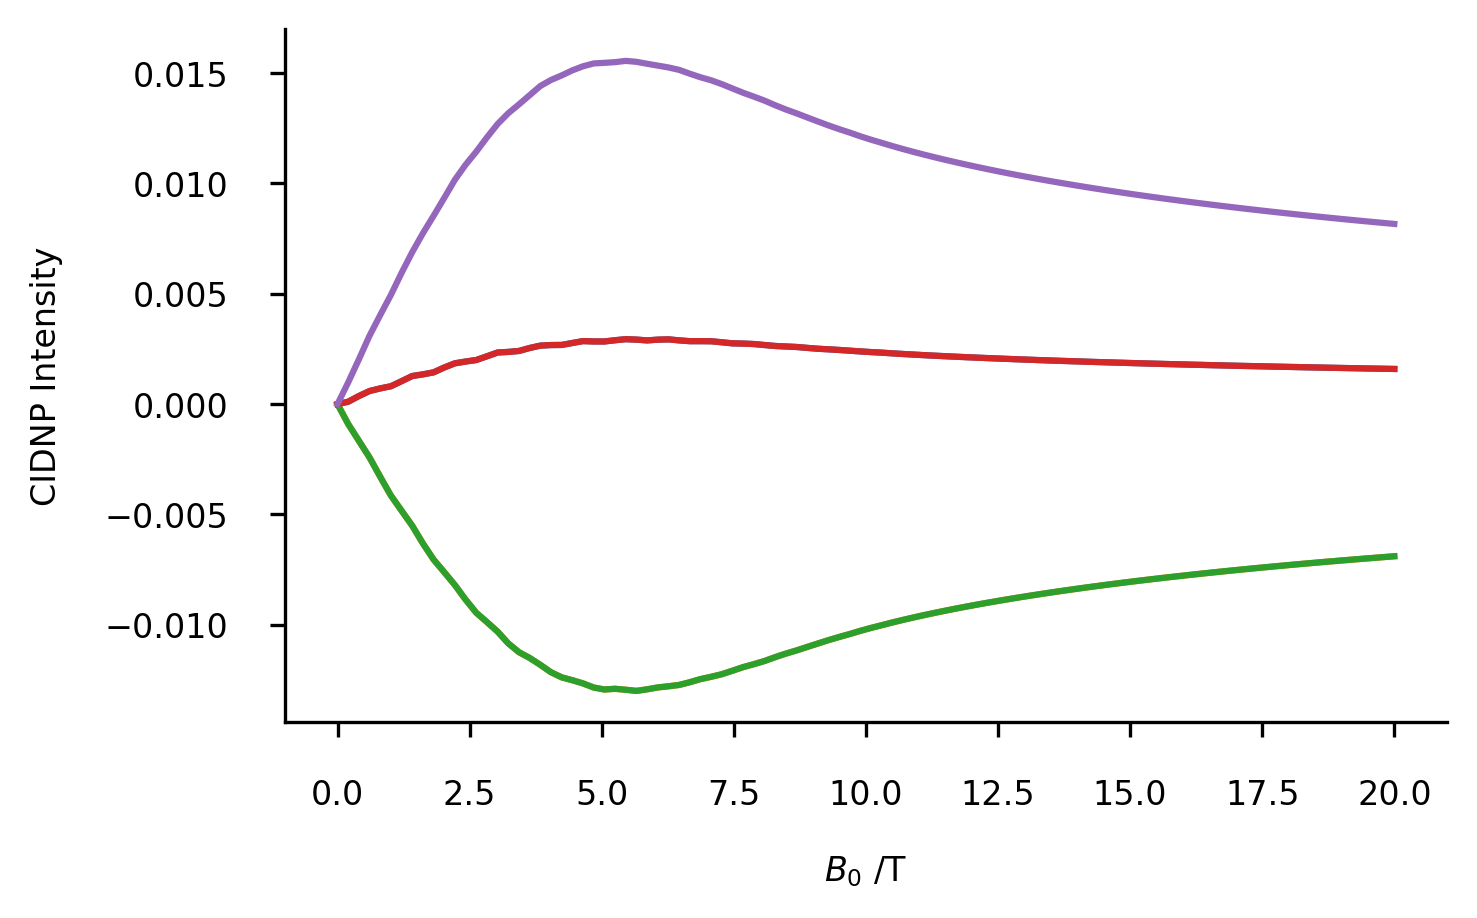

In [10]:
deltag = tyr_neutral_g - fmn_neutral_g
Bs = np.linspace(0.0, 20.0, 100)

for i in range(1,6):
    B0, p = cidnp(
        B0=Bs,
        deltag=deltag,
        cidnp_model="c", 
        ks=5e8,
        alpha=1.5,
        nucleus_of_interest=i,
        donor_hfc_spinhalf=[0.15, -0.65, -0.65, 0.15, 0.77],
        acceptor_hfc_spinhalf=[0.390, -0.769, -0.17, 0.24],
        donor_hfc_spin1=[],
        acceptor_hfc_spin1=[0.393, 0.212],
    )
    plt.plot(B0, p)


plt.xlabel("$B_0$ /T", size=8)
plt.ylabel("CIDNP Intensity", size=8)
plt.tick_params(labelsize=8)
plt.gcf().set_size_inches(5, 3)
plt.show()


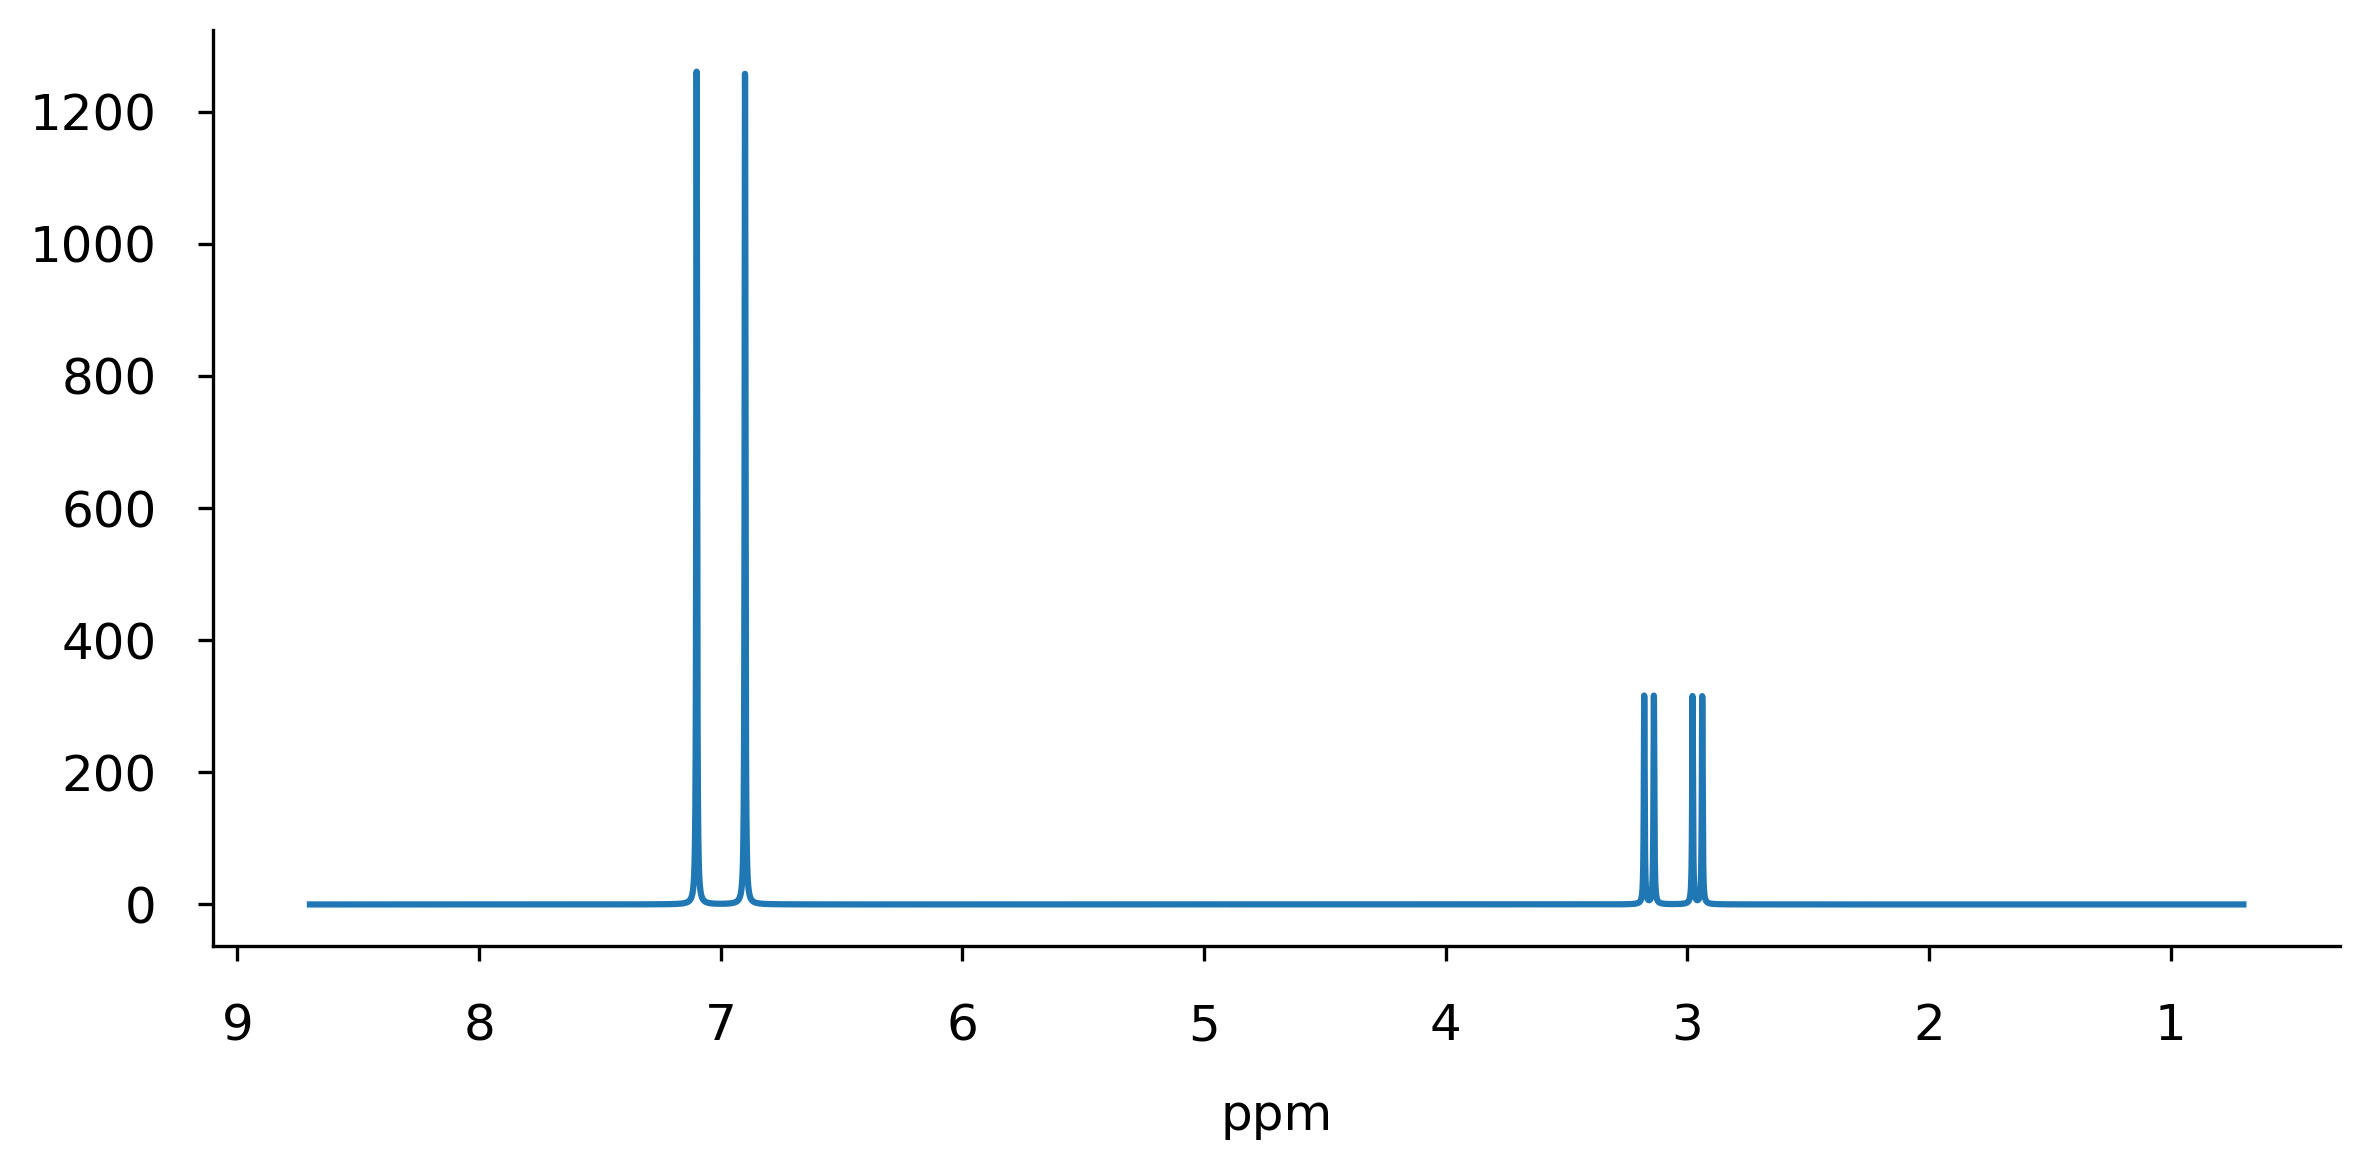

In [14]:
# Simulate and plot a simple 1D NMR spectrum

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------- Core Functions ----------------------------- #
def nmr_chemical_shift_real_modulation(freq_hz: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Chemical-shift modulation (real): cos(2π f t)."""
    return np.cos(2.0 * np.pi * np.multiply.outer(freq_hz, t))

def nmr_chemical_shift_imaginary_modulation(freq_hz: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Chemical-shift modulation (imag): sin(2π f t)."""
    return np.sin(2.0 * np.pi * np.multiply.outer(freq_hz, t))

def nmr_scalar_coupling_modulation(j_hz: np.ndarray, t: np.ndarray, mult_minus_one: np.ndarray) -> np.ndarray:
    """J-modulation: cos(π J t) ** (mult - 1)."""
    base = np.cos(np.pi * np.multiply.outer(j_hz, t))
    return np.where(mult_minus_one[:, None] > 0, base ** mult_minus_one[:, None], 1.0)

def nmr_t2_relaxation(t: np.ndarray, t2: float) -> np.ndarray:
    """T2 relaxation decay: exp(-t / T2)."""
    return np.exp(-t / t2)

# ----------------------------- Parameters -------------------------------- #
# You can tweak these if you'd like to see different peak patterns
SW_HZ        = 4000.0   # spectral width (Hz)
NP           = 8000   # acquired points
N_FFT        = 16000    # zero-filled FFT length
TRANS_MHZ    = 500.0    # transmitter frequency (MHz)
CARRIER_PPM  = 4.7      # carrier position (ppm)
LINEWIDTH_HZ = 2.0      # Lorentzian linewidth (Hz)
SCALE        = 1.0      # final y-scale

# TRANS_MHZ   = 500.0           # Spectrometer frequency (MHz)
# CARRIER_PPM = 4.7             # Carrier position (ppm)
# SW_HZ       = 8000.0          # Spectral width (Hz)
# NP          = 16384           # Acquired points
# N_FFT       = 32768           # FFT length (>= NP), controls zero-filling
# LINEWIDTH_HZ= 2.5             # Lorentzian FWHM (Hz) used for T2 in FID

# Multiplets: (No. of nuclei, frequency (Hz), multiplicity, J (Hz)) 
# for CIDNP, just replace No. of nuclei with the CIDNP intensity at the proton frequency
# e.g., 500 MHz = 11.75 T
MULTIPLETS = [
    (2.0,  800.0, 2, 0),  # singlet @ +1000 Hz
    (2.0,  900.0, 2, 0),  # singlet @ +1000 Hz
    (1.0,  2870.0, 2, 20),  # triplet @ -600 Hz, J=7 Hz
    (1.0,  2770.0, 2, 20),  # triplet @ -600 Hz, J=7 Hz
]

# ----------------------------- Simulation -------------------------------- #
# Derived quantities
dw      = 1.0 / SW_HZ
at      = NP * dw
digres  = SW_HZ / N_FFT
t2      = 1.0 / (np.pi * LINEWIDTH_HZ) if LINEWIDTH_HZ > 0 else 1e99
reffreq = TRANS_MHZ / (1.0 + CARRIER_PPM * 1.0e-6)

# Time array (i=1..NP): t = ((i-1)*at)/(NP-1)
time = np.linspace(0.0, at, NP, endpoint=True)

# Multiplet arrays
if len(MULTIPLETS) > 0:
    arr  = np.array(MULTIPLETS, dtype=float)
    nnuc = arr[:, 0]  # number of nuclei
    f_hz = arr[:, 1]  # frequency
    mult = arr[:, 2].astype(int)  # multiplicity
    j_hz = arr[:, 3]  # J
else:
    nnuc = np.zeros(0)
    f_hz = np.zeros(0)
    mult = np.zeros(0, dtype=int)
    j_hz = np.zeros(0)

# Build FID (vectorized)
if len(MULTIPLETS) > 0:
    cs_re = nmr_chemical_shift_real_modulation(f_hz, time)        # (n_mult, NP)
    cs_im = nmr_chemical_shift_imaginary_modulation(f_hz, time)        # (n_mult, NP)
    jpow  = nmr_scalar_coupling_modulation(j_hz, time, mult - 1)
    decay = nmr_t2_relaxation(time, t2)          # (NP,)

    rfid = np.sum(nnuc[:, None] * cs_re * jpow, axis=0) * decay
    ifid = np.sum(nnuc[:, None] * cs_im * jpow, axis=0) * decay
else:
    rfid = np.zeros(NP)
    ifid = np.zeros(NP)

# Scale the first point
rfid[0] *= 0.5
ifid[0] *= 0.5

# Zero-fill
if N_FFT > NP:
    pad_len = N_FFT - NP
    rfid = np.concatenate([rfid, np.zeros(pad_len)])
    ifid = np.concatenate([ifid, np.zeros(pad_len)])

# FFT
fid  = rfid + 1j * ifid
spec = np.fft.fft(fid, n=N_FFT)

# Frequency (MHz)
i = np.arange(1, N_FFT + 1, dtype=float)
freq_mhz = ((TRANS_MHZ * 1.0e6) + (SW_HZ / 2.0) - ((i - 1.0) * SW_HZ) / (N_FFT - 1.0)) / 1.0e6
ppm = ((freq_mhz - reffreq) / reffreq) * 1.0e6

# ------------------------------- Plot ------------------------------------ #
plt.figure(figsize=(8, 4))
plt.plot(ppm, spec.real * SCALE)
plt.gca().invert_xaxis()  # Conventional NMR display: high ppm on the left
plt.xlabel("ppm")
# plt.ylabel("Intensity (a.u.)")
# plt.title("Simulated 1D NMR Spectrum")
plt.tight_layout()
plt.show()
